In [207]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import networkx as nx
import pylab
from tqdm import tqdm
import math

In [55]:
nodes = pd.read_csv('cleaned_top_ingreds.csv')
nodes = nodes.drop('Unnamed: 0', axis=1)
edges = pd.read_csv('filtered_pairs.csv')
edges = edges.drop('Unnamed: 0', axis=1)

In [56]:
print(nodes.shape, edges.shape)

(196, 3) (17833, 4)


In [165]:
# Generating total edge count for each ingredient

edge_count_df = edges.groupby('ingred1').agg({'counts':'sum'}).join(edges.groupby('ingred2').agg({'counts':'sum'}), lsuffix='1', rsuffix='2').fillna(0)
edge_count_df['total_edges'] = (edge_count_df['counts1'] + edge_count_df['counts2']).astype('int')
edge_count_df = edge_count_df.drop(['counts1','counts2'],axis=1)
edge_count_df.head(20)

total_edges
ingred1                           
all-purpose flour           174402
almond                       14392
almond extract                7934
apple                         7247
avocado                       9002
bacon                        16050
baking powder                68695
baking soda                  56018
balsamic vinegar             16894
banana                        5902
basil                        34375
bay leaf                     41241
beef broth                    7213
bittersweet chocolate         8581
black bean                    9774
black olive                   6580
black peppercorn             14057
blue cheese                   4404
bread crumb                  21027
brown sugar                  87258

In [59]:
# Check on total ingredients present

len(list(set(list(edges['ingred1'].unique()) + list(edges['ingred2'].unique()))))

196

## Weighting options

1. Averaged ratio between two ingredients
2. One sided ratio between two ingredients
3. inverse recipe frequency twoway (total)

In [205]:
nodes.head()

ingredient   total  recipes
0     butter  421929    36975
1     garlic  384999    32539
2      sugar  383695    31492
3  olive oil  377461    32429
4        egg  257308    24435

In [213]:
# weight 3: IF-IRF calculation

# ingredient-pair frequency - inverse recipe frequency IF-IRF
# (1 + log(1 + IF)) * log(total recipes / recipe frequency)

raw_total_recipes = 122971

for row in tqdm(edges.itertuples()):
    edges.loc[row[0],'ingred1_recipe_count'] = nodes.loc[nodes['ingredient'] == row[3], 'recipes'].item()
    edges.loc[row[0],'ingred2_recipe_count'] = nodes.loc[nodes['ingredient'] == row[4], 'recipes'].item()

edges['comb_recipe_count'] = edges['ingred1_recipe_count'] + edges['ingred2_recipe_count']

edges['counts'] = edges['counts'].astype('float64')
edges['comb_recipe_count'] = edges['comb_recipe_count'].astype('float64')

edges['IF'] = 1 + np.log10(1 + edges['counts'])
edges['IRF'] = np.log10(raw_total_recipes / edges['comb_recipe_count'])
edges['IF-IRF'] = edges['IF'] * edges['IRF']

17833it [00:31, 567.23it/s]


pairs   counts  \
0                     ('all-purpose flour', 'almond')    657.0   
1             ('all-purpose flour', 'almond extract')    634.0   
2                      ('all-purpose flour', 'apple')    356.0   
3                    ('all-purpose flour', 'avocado')     53.0   
4                      ('all-purpose flour', 'bacon')    411.0   
5              ('all-purpose flour', 'baking powder')   6721.0   
6                ('all-purpose flour', 'baking soda')   5199.0   
7           ('all-purpose flour', 'balsamic vinegar')    141.0   
8                     ('all-purpose flour', 'banana')    247.0   
9                      ('all-purpose flour', 'basil')    466.0   
10                  ('all-purpose flour', 'bay leaf')    788.0   
11                ('all-purpose flour', 'beef broth')    274.0   
12     ('all-purpose flour', 'bittersweet chocolate')    424.0   
13                ('all-purpose flour', 'black bean')     45.0   
14               ('all-purpose flour', 'black olive')     69.0   
15          ('all-purpose flour', 'black peppercorn')    171.0   
16               ('all-purpose flour', 'blue cheese')     70.0   
17               ('all-purpose flour', 'bread crumb')    647.0   
18               ('all-purpose flour', 'brown sugar')   4776.0   
19                    ('all-purpose flour', 'butter')  18382.0   
20                ('all-purpose flour', 'buttermilk')   1645.0   
21          ('all-purpose flour', 'butternut squash')     93.0   
22                ('all-purpose flour', 'cake flour')    195.0   
23                  ('all-purpose flour', 'cake mix')     58.0   
24                ('all-purpose flour', 'canola oil')    976.0   
25                     ('all-purpose flour', 'caper')    134.0   
26                    ('all-purpose flour', 'carrot')   1046.0   
27                   ('all-purpose flour', 'cayenne')    172.0   
28                    ('all-purpose flour', 'celery')    838.0   
29            ('all-purpose flour', 'cheddar cheese')    568.0   
...                                               ...      ...   
17803                  ('whole clove', 'sweet onion')      2.0   
17804                   ('whole clove', 'whole milk')     27.0   
17805                 ('whole clove', 'wine vinegar')     53.0   
17806         ('whole clove', 'worcestershire sauce')     12.0   
17807                     ('whole clove', 'zucchini')      6.0   
17808                   ('whole milk', 'feta cheese')      9.0   
17809                    ('whole milk', 'fish sauce')      1.0   
17810                 ('whole milk', 'salmon fillet')      4.0   
17811                    ('whole milk', 'sesame oil')      2.0   
17812                  ('whole milk', 'wine vinegar')     33.0   
17813          ('whole milk', 'worcestershire sauce')     64.0   
17814                      ('whole milk', 'zucchini')     14.0   
17815              ('wine vinegar', 'chocolate chip')      3.0   
17816               ('wine vinegar', 'food coloring')      1.0   
17817                  ('wine vinegar', 'shortening')      1.0   
17818        ('wine vinegar', 'worcestershire sauce')    286.0   
17819                    ('wine vinegar', 'zucchini')    134.0   
17820             ('worcestershire sauce', 'coconut')      2.0   
17821       ('worcestershire sauce', 'corn tortilla')     12.0   
17822     ('worcestershire sauce', 'dried cranberry')      4.0   
17823       ('worcestershire sauce', 'food coloring')      2.0   
17824           ('worcestershire sauce', 'ice cream')      1.0   
17825            ('worcestershire sauce', 'zucchini')     23.0   
17826                          ('zucchini', 'banana')      2.0   
17827                      ('zucchini', 'cake flour')      3.0   
17828              ('zucchini', 'confectioner sugar')     18.0   
17829                      ('zucchini', 'corn syrup')      1.0   
17830                        ('zucchini', 'ice cube')      2.0   
17831             ('zucchini', 'semisweet chocolate')      2.0   
17832                 

In [220]:
edges.sort_values(by='IF-IRF', ascending=False)

pairs  counts             ingred1  \
7257          ('coriander seed', 'cumin seed')   369.0      coriander seed   
6610         ('cinnamon stick', 'whole clove')   505.0      cinnamon stick   
7320        ('coriander seed', 'mustard seed')   175.0      coriander seed   
8544            ('cumin seed', 'mustard seed')   177.0          cumin seed   
7269         ('coriander seed', 'fennel seed')   211.0      coriander seed   
10657        ('flour tortilla', 'jack cheese')   155.0      flour tortilla   
16789           ('rice vinegar', 'sesame oil')   597.0        rice vinegar   
17001            ('sesame oil', 'sesame seed')   712.0          sesame oil   
6890            ('coconut milk', 'fish sauce')   206.0        coconut milk   
10464                 ('fish sauce', 'peanut')   109.0          fish sauce   
15178  ('mozzarella cheese', 'ricotta cheese')   260.0   mozzarella cheese   
2607    ('black peppercorn', 'coriander seed')   272.0    black peppercorn   
2742       ('black peppercorn', 'whole clove')   257.0    black peppercorn   
12422      ('ground allspice', 'ground clove')   359.0     ground allspice   
3765            ('cake flour', 'cream tartar')   136.0          cake flour   
12726        ('ground clove', 'ground ginger')   577.0        ground clove   
7663          ('corn tortilla', 'jack cheese')   123.0       corn tortilla   
16790          ('rice vinegar', 'sesame seed')   277.0        rice vinegar   
16195              ('peanut', 'peanut butter')   186.0              peanut   
10085           ('fennel bulb', 'fennel seed')   110.0         fennel bulb   
11669        ('garlic powder', 'onion powder')  1117.0       garlic powder   
8598             ('cumin seed', 'whole clove')   129.0          cumin seed   
14015               ('jalapeno', 'juice lime')   135.0            jalapeno   
6405                    ('cinnamon', 'nutmeg')   245.0            cinnamon   
9569              ('dry yeast', 'wheat flour')   155.0           dry yeast   
8495             ('cumin seed', 'fennel seed')   129.0          cumin seed   
6877          ('coconut milk', 'curry powder')   213.0        coconut milk   
5557      ('chile powder', 'ground coriander')   113.0        chile powder   
15472                   ('oat', 'wheat flour')    84.0                 oat   
5622         ('chile powder', 'spanish onion')    60.0        chile powder   
...                                        ...     ...                 ...   
16170           ('parsley', 'vanilla extract')     3.0             parsley   
3292                      ('butter', 'garlic')  8409.0              butter   
17522      ('tomato paste', 'vanilla extract')     1.0        tomato paste   
3341                   ('butter', 'olive oil')  7617.0              butter   
15652              ('olive oil', 'shortening')    13.0           olive oil   
1575                      ('banana', 'garlic')    13.0              banana   
3315                    ('butter', 'ice cube')    21.0              butter   
15730             ('onion', 'vanilla extract')    10.0               onion   
17622          ('vanilla extract', 'scallion')     1.0     vanilla extract   
11602               ('garlic', 'vanilla bean')    11.0              garlic   
3779                  ('cake flour', 'garlic')    10.0          cake flour   
17618       ('vanilla extract', 'green onion')     1.0     vanilla extract   
15620           ('olive oil', 'food coloring')     9.0           olive oil   
13665               ('ice cream', 'olive oil')    10.0           ice cream   
4740             ('celery', 'vanilla extract')     1.0              celery   
8323             ('cream tartar', 'olive oil')     8.0        cream tartar   
15682              ('onion', 'almond extract')     2.0               onion   
15728                     ('onion', 'vanilla')     2.0               onion   
15683                   ('onion', 'ice cream')     2.0               onion   
17621         ('vanilla extract', 'red onion')     1.0     vani

In [64]:
G = nx.Graph()

In [67]:
# Add edges and edge attributes
for i, elrow in edges.iterrows():
    G.add_edge(elrow[2], elrow[3], attr_dict=elrow[0:2].to_dict())

In [72]:
# Add node attributes
for i, nlrow in nodes.iterrows():
    G.add_node(nlrow['ingredient'], attr_dict=nlrow[1:].to_dict())

In [144]:
recipe_count_map = [x[1]['attr_dict']['recipes'] for x in list(G.nodes(data=True))]

/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


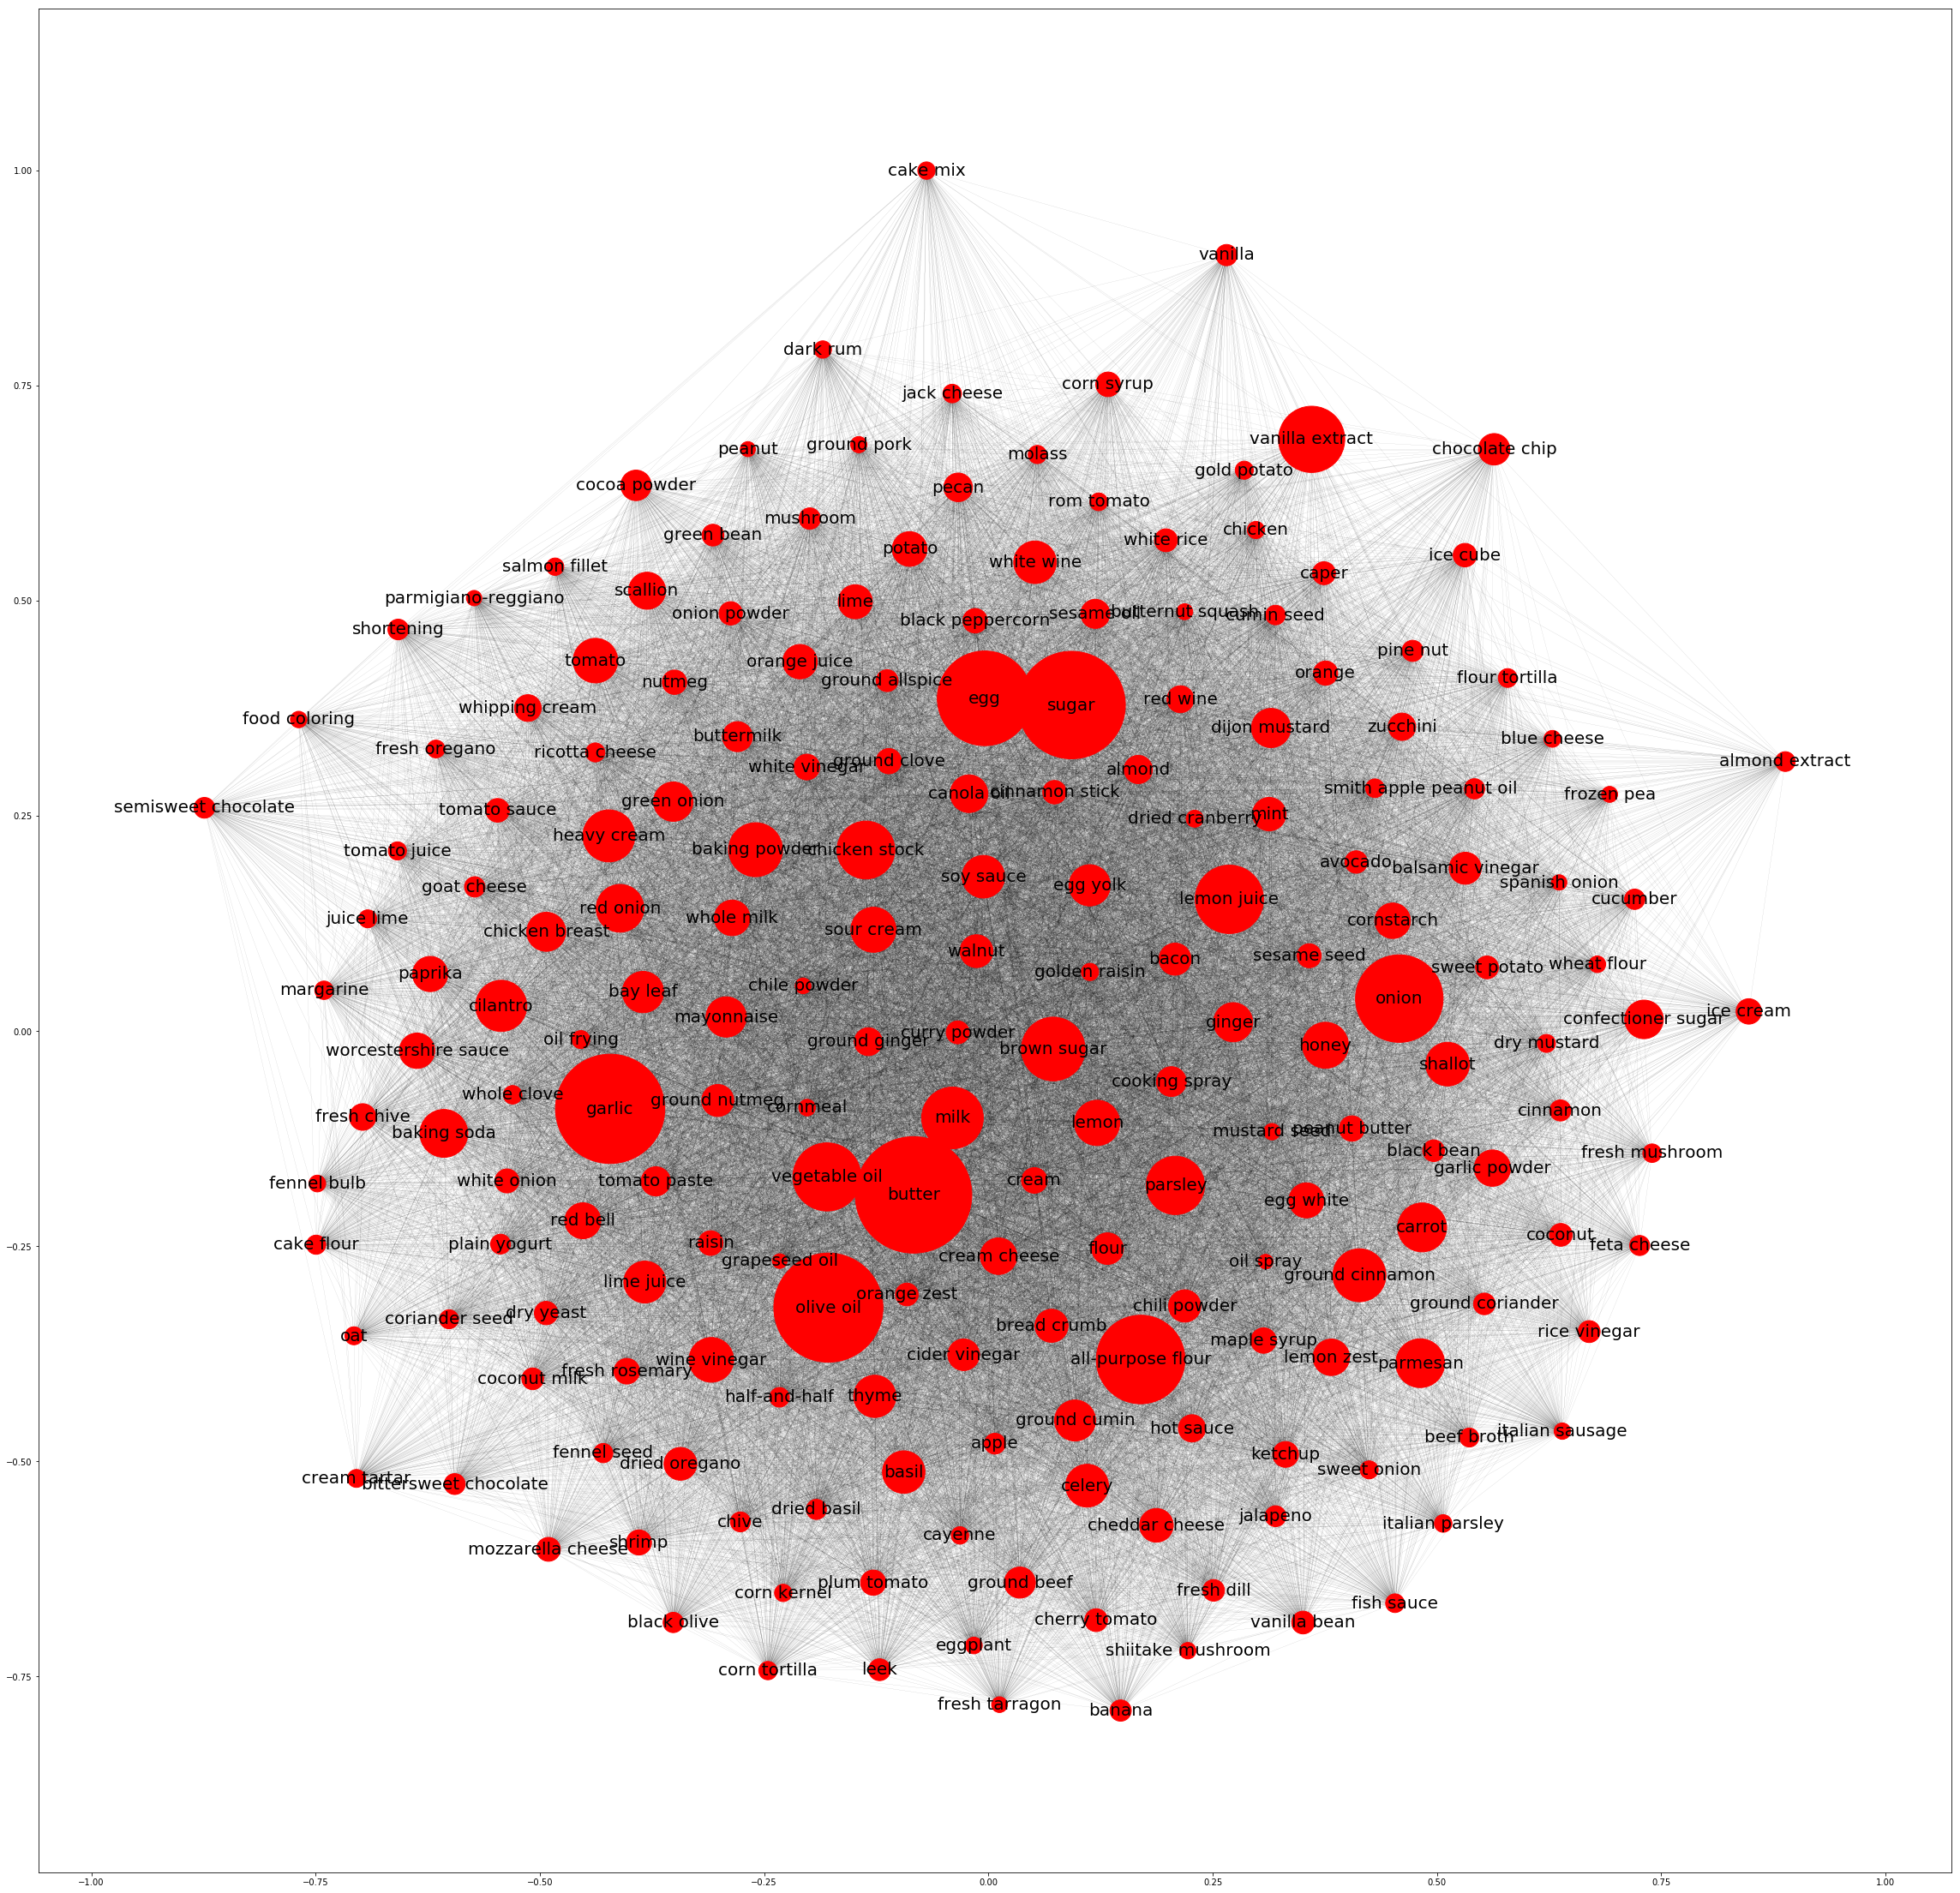

In [147]:
plt.figure(figsize=(40,40))
pos=nx.spring_layout(G, k=1.5)
nx.draw_networkx(G, pos, font_color='black', font_size=20, width=0.05, node_size=[count/2 for count in recipe_count_map])

/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


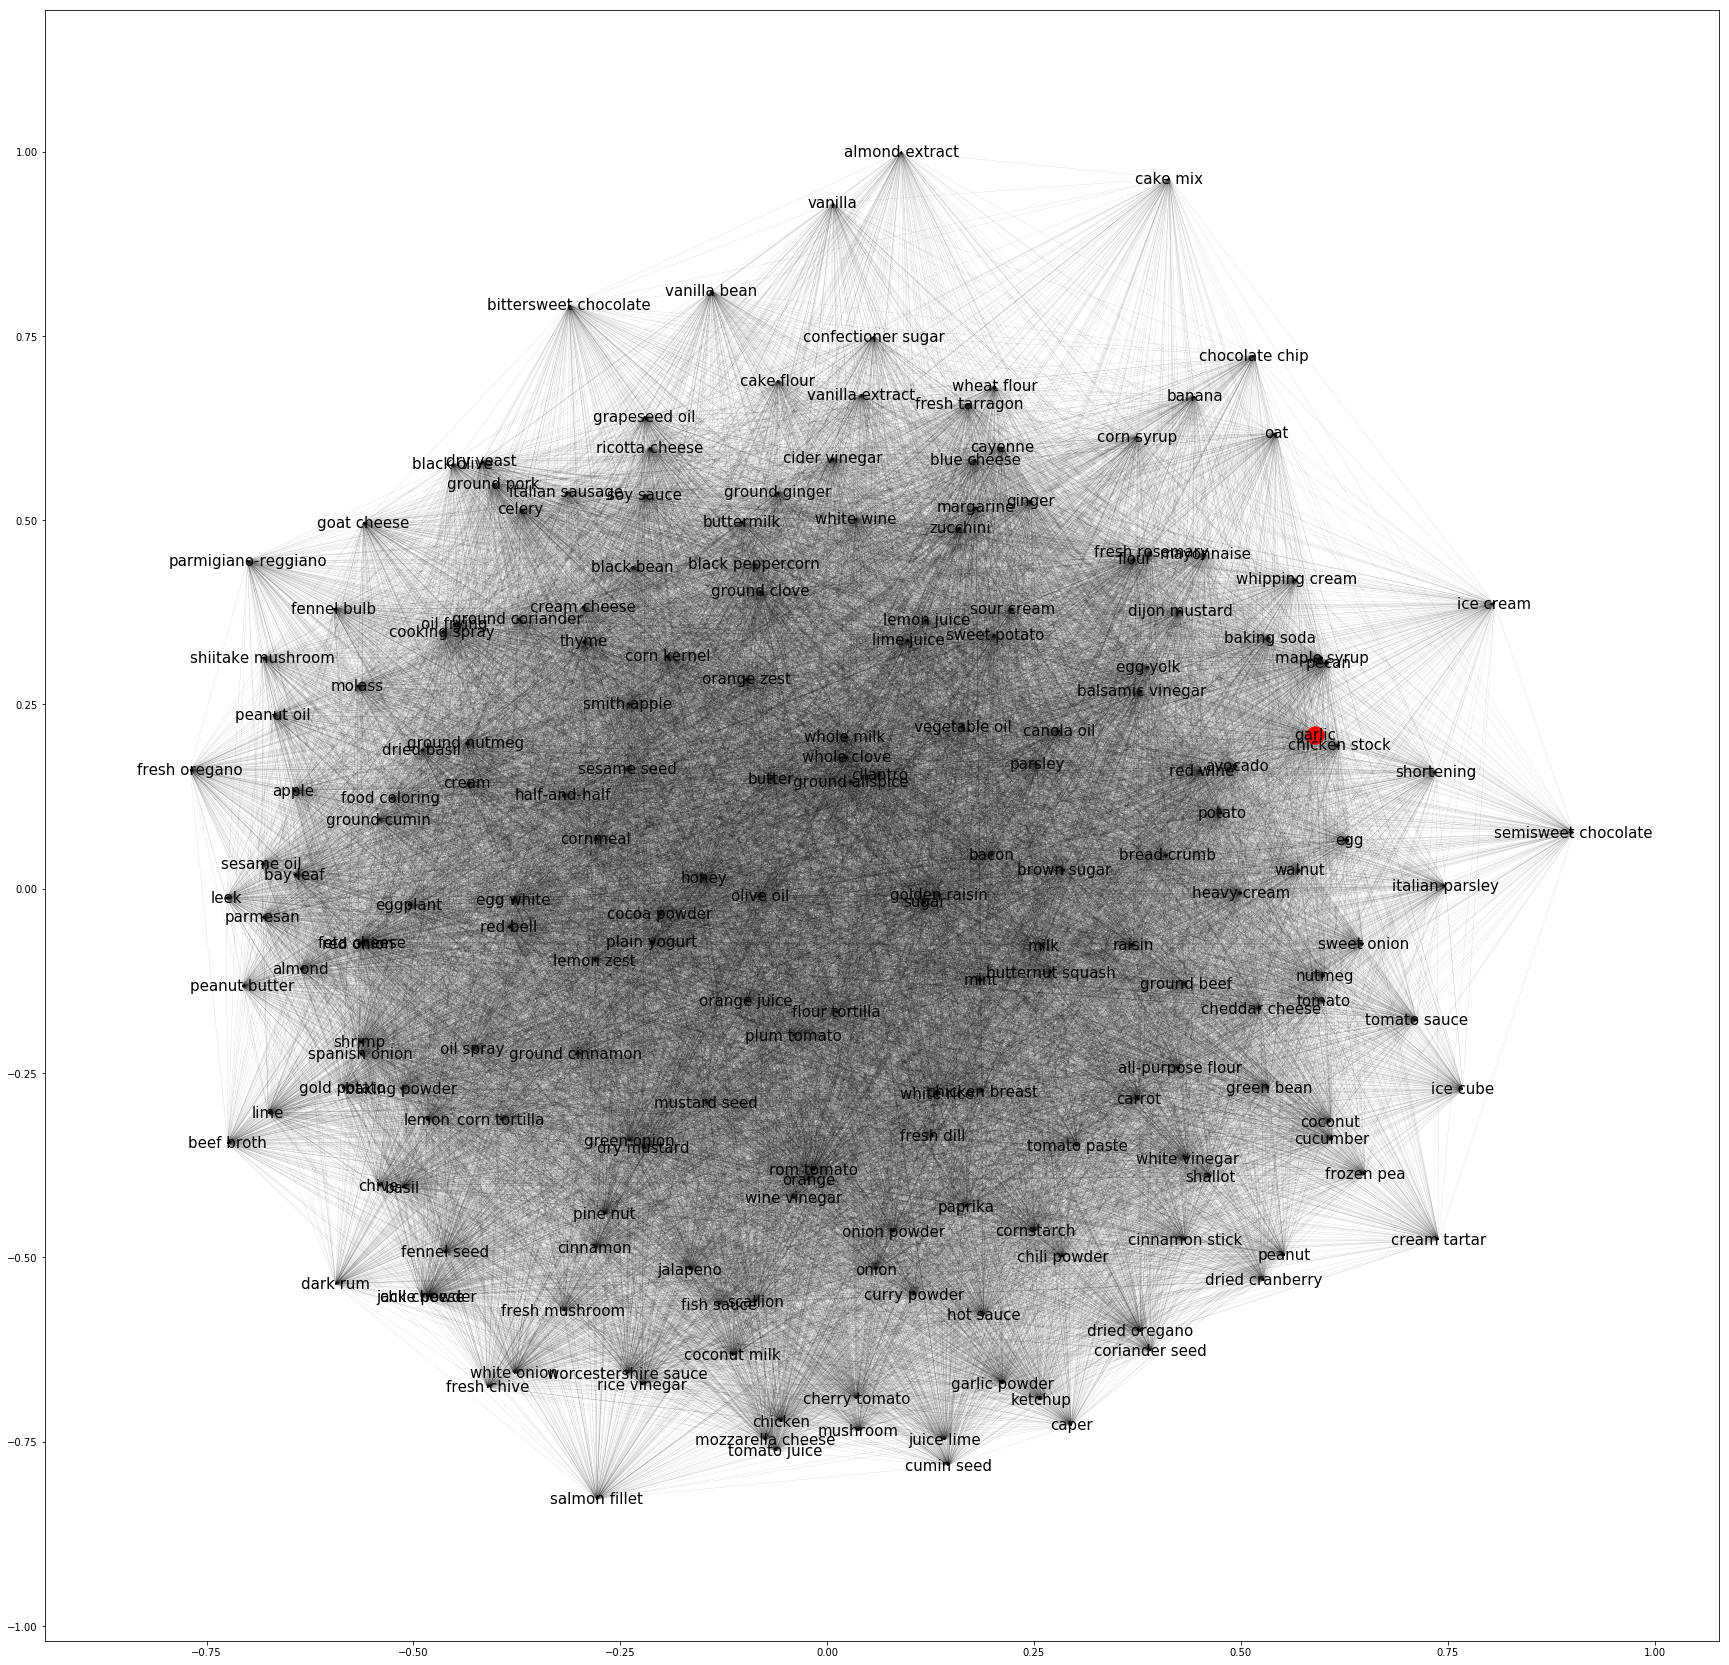

In [114]:
plt.figure(figsize=(30,30))
pos=nx.spring_layout(G)
nx.draw_networkx(G, font_color='black', font_size=15, width=0.05, nodelist=list(G.nodes())[1:2])